# Feature Engineering and Modeling

Note: The following code and document are partly adapted from Dr.Shan's Python Clinics code


In [1]:
#Loading necessary libraries
import nltk
import spacy
from pymongo import MongoClient
import json
from bson import json_util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import spacy
import nltk
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
import gzip
from pandas.io.json import json_normalize
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
df = pd.read_csv("cleaned_data.csv", sep=',')
df = df.sample(frac=0.05, random_state=1).reset_index()

In [31]:
df.head()

,index,Unnamed: 0,reviewText,brand,helpful_no,helpful_yes,target,price_cleaned,title_com,alltext_com
0,2745836,2745836,great when it works. if it loses connection co...,Edimax,0,0,0,9.55,0.132049,0.425618
1,2372951,2372951,this tablet exceeded my expectations in terms ...,Asus,3,5,1,178.99,0.034178,0.034178
2,2475283,2475283,"the replacement did do the job. however, the &...",NG,1,1,0,17.35,0.027854,0.027854
3,1935443,1935443,i have five internal and external hard drives ...,Vantec,0,0,1,18.99,0.059556,0.366812
4,2239297,2239297,this is exactly what i needed for a yagi anten...,TP-LINK,2,2,1,13.75,0.041198,0.472550


In [ ]:
corpus_cleaned1 = []
nlp = spacy.load("en_core_web_sm")
for text in df['reviewText']:
    # Seperate text into individual words
    tokens = word_tokenize(str(text))

    # Remove the punctuations and numbers
    tokens = [word for word in tokens if word.isalpha()]

    # Remove stopword
    tokens = [word for word in tokens if not word in stopwords.words("english")]

    # Stem the tokens
    ps = PorterStemmer()
    tokens = [ps.stem(w) for w in tokens]

    text_cleaned = " ".join(tokens)

    corpus_cleaned1.append(text_cleaned)
    
df = df.assign(reviewTokens = corpus_cleaned1)

### Sentiment Analysis with VADER

In [40]:
# initiate an analyzer
def sentimentScores(df, corpus):
    sia = SentimentIntensityAnalyzer()

    comp = []

    # iterate through each sentence in corpus
    for sentence in corpus:
        # analyze the sentiment. ss is a dictionary
        ss = sia.polarity_scores(sentence)

        # output each sentiment score (neg, neu, pos, compound) in ss
        comp.append(ss['compound'])
    
    df_new = df.assign(reviews_vader_comp = comp)
    return df_new

In [41]:
brand_reviews = sentimentScores(df, df['reviewTokens'])

In [42]:
brand_reviews.head()

,index,Unnamed: 0,reviewText,helpful_no,helpful_yes,target,price_cleaned,title_com,alltext_com,reviewTokens,reviews_vader_comp
0,2745836,2745836,great when it works. if it loses connection co...,0,0,0,9.55,0.132049,0.425618,great work lose connect constantli connect sta...,-0.0772
1,2372951,2372951,this tablet exceeded my expectations in terms ...,3,5,1,178.99,0.034178,0.034178,tablet exceed expect term use endless possibl ...,-0.2023
2,2475283,2475283,"the replacement did do the job. however, the &...",1,1,0,17.35,0.027854,0.027854,replac job howev unexpect way actual fit batte...,0.6621
3,1935443,1935443,i have five internal and external hard drives ...,0,0,1,18.99,0.059556,0.366812,five intern extern hard drive want test devic ...,-0.1280
4,2239297,2239297,this is exactly what i needed for a yagi anten...,2,2,1,13.75,0.041198,0.472550,exactli need yagi antenna amplifi attach anten...,0.1857


### K-Means Clustering with Word2Vec Model


#### Word2Vec Model

In [44]:
documents = [nltk.word_tokenize(sent) for sent in brand_reviews['reviewTokens']]

In [45]:
wv_model = Word2Vec(documents, window=10, min_count=5, workers=10)
wv_model.train(documents, total_examples=len(documents),epochs=10)

(53026442, 58145300)

In [46]:
wv_model.save("w2vModel_brand_reviews.model")

In [47]:
word_vectors= Word2Vec.load("w2vModel_brand_reviews.model").wv

In [48]:
w1 = "good"
wv_model.wv.most_similar(positive=w1)

[('decent', 0.7863881587982178),
 ('great', 0.7453351616859436),
 ('excel', 0.6783779263496399),
 ('nice', 0.5760012865066528),
 ('awesom', 0.5373095870018005),
 ('terrif', 0.5282060503959656),
 ('fantast', 0.5134875178337097),
 ('ok', 0.5109250545501709),
 ('okay', 0.5011830925941467),
 ('outstand', 0.5004854202270508)]

#### K Means Clustering with Word2Vec

In [51]:
model_kmeans=KMeans(n_clusters=2, max_iter=10000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [52]:
word_vectors.similar_by_vector(model_kmeans.cluster_centers_[0], topn=50,restrict_vocab=None)

[('justo', 0.8239935040473938),
 ('esperaba', 0.8210289478302002),
 ('dinero', 0.8148132562637329),
 ('bajo', 0.7983721494674683),
 ('mismo', 0.7981988787651062),
 ('medio', 0.7945559024810791),
 ('entrega', 0.791122317314148),
 ('cumpl', 0.7910991907119751),
 ('instalar', 0.7898241877555847),
 ('cosa', 0.788453221321106),
 ('momento', 0.7874630689620972),
 ('dia', 0.7862640619277954),
 ('comprado', 0.7848004698753357),
 ('aun', 0.7843344211578369),
 ('cumpli', 0.7841208577156067),
 ('trae', 0.7836933732032776),
 ('computadora', 0.7832279205322266),
 ('mucha', 0.7819949984550476),
 ('mapa', 0.7808349132537842),
 ('teclado', 0.7807285189628601),
 ('necesidad', 0.7806126475334167),
 ('crippen', 0.7771453261375427),
 ('instalaci', 0.7754659056663513),
 ('relaci', 0.7742890119552612),
 ('vez', 0.7729901671409607),
 ('estar', 0.7727069854736328),
 ('queda', 0.7726653218269348),
 ('poco', 0.7726359367370605),
 ('espero', 0.7726022601127625),
 ('sonido', 0.7701442241668701),
 ('ahora', 0.7701

In [53]:
positive_cluster_index = 1   #defining clusters
positive_cluster_center = model_kmeans.cluster_centers_[positive_cluster_index]
negative_cluster_center = model_kmeans.cluster_centers_[1-positive_cluster_index]

In [54]:
words = pd.DataFrame(word_vectors.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model_kmeans.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model_kmeans.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [55]:
words.head(10)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,great,"[1.1501452, 1.661074, -1.5643018, -2.0496254, ...",0,-1,0.064705,-0.064705
1,work,"[-0.16120513, -1.8426865, -0.4980783, 1.542036...",0,-1,0.063665,-0.063665
2,lose,"[-0.5732133, -0.82135546, 1.5684389, -1.815141...",1,1,0.059529,0.059529
3,connect,"[-2.6905372, 1.1629049, -0.7213434, 2.2820919,...",0,-1,0.048562,-0.048562
4,constantli,"[0.46249694, 1.0807141, -0.08913288, -3.016909...",0,-1,0.067206,-0.067206
5,startup,"[-0.2081313, 1.6105258, 2.2592063, -0.90023136...",0,-1,0.077211,-0.077211
6,frequent,"[-0.059866976, -0.3078387, 0.012063537, -2.493...",0,-1,0.067844,-0.067844
7,problem,"[-1.1121883, -0.9754747, 1.5763533, -1.2258955...",0,-1,0.058447,-0.058447
8,softwar,"[1.1837375, -1.7276136, -2.038646, -0.05674517...",0,-1,0.045814,-0.045814
9,creat,"[-2.624349, -1.245148, -0.21807899, 0.6985172,...",0,-1,0.068409,-0.068409


In [56]:
words[['words', 'sentiment_coeff']].to_csv('brand_reviews_sentiment_dictionary.csv', index=False) #saving sentiment dictionary

In [66]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    Return
    replacing each word with its associated sentiment score from sentiment dict

    Args:
    word: single token text
    sentiment_dict: Dictionary created with Word2Vec Model with K Means Clustering
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [67]:
sentiment_map = pd.read_csv('brand_reviews_sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [103]:
brand_reviews['replaced_closeness_scores'] = brand_reviews.reviewTokens.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))
brand_reviews['avg_closeness_score'] = brand_reviews.apply(lambda x: np.average(np.array(x.loc['replaced_closeness_scores'])), axis=1)

In [105]:
brand_reviews.avg_closeness_score = brand_reviews.avg_closeness_score.transform(lambda x: x.fillna(x.mean()))

In [106]:
brand_reviews.isna().sum()/len(brand_reviews)

index                        0.000000
Unnamed: 0                   0.000000
reviewText                   0.000402
helpful_no                   0.000000
helpful_yes                  0.000000
target                       0.000000
price_cleaned                0.000000
title_com                    0.000000
alltext_com                  0.000000
reviewTokens                 0.000000
reviews_vader_comp           0.000000
replaced_closeness_scores    0.000000
avg_closeness_score          0.000000
dtype: float64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
  
#Passing encoded columns
'''
NOTE: we have converted the enc.fit_transform() method to array because the fit_transform method 
of OneHotEncoder returns SpiPy sparse matrix this enables us to save space when we 
have huge  number of categorical variables
'''
enc_data=pd.DataFrame(enc.fit_transform(brand_reviews['brand']).toarray())
  
#Merge with main
brand_reviews_cleaned=brand_reviews.join(enc_data)

In [ ]:
# ##Potential PCA for brand column

# ## example we read only the response AND the categorical variable of interest  
# df_to_collapse = brand_reviews_pca[['target', 'brand']]
# df_to_collapse = pd.get_dummies(df_to_collapse, drop_first = True)
# df_to_collapse.head(10)
# # next import the random forest
# from sklearn.ensemble import RandomForestClassifier

# ## we fit the random forest
# rf = RandomForestClassifier()
# rf.fit(df_to_collapse.drop('brand', axis = 1), df_to_collapse['brand'])


# feature_importances = pd.DataFrame({'Variable' :df_to_collapse.drop('brand', axis = 1).columns, 'Importance': rf.feature_importances_})
# feature_importances.set_index('Variable', inplace = True)
# feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False)
# feature_importances.head(20)

In [107]:
brand_reviews_cleaned = brand_reviews.drop(["index", "Unnamed: 0", "reviewText", "reviewTokens", "replaced_closeness_scores", "brand"], axis = 1)
brand_reviews_cleaned.to_csv("modeling_dat.csv")

In [108]:
brand_reviews_cleaned.isna().sum()/len(brand_reviews_cleaned)

helpful_no             0.0
helpful_yes            0.0
target                 0.0
price_cleaned          0.0
title_com              0.0
alltext_com            0.0
reviews_vader_comp     0.0
avg_closeness_score    0.0
dtype: float64

In [109]:
X_reddit = brand_reviews_cleaned.drop(['target'], axis = 1)
y_reddit = brand_reviews_cleaned['target']
X_no_reddit = brand_reviews_cleaned.drop(['target','title_com', 'alltext_com'], axis = 1)
y_no_reddit = brand_reviews_cleaned['target']

#### keep 30% data for testing and 70% for training and cv

In [112]:
from sklearn.model_selection import train_test_split
X_train_reddit_imbal, X_test_reddit, y_train_reddit_imbal, y_test_reddit = train_test_split(X_reddit, y_reddit, test_size=0.3, random_state=0)
X_train_no_reddit_imbal, X_test_no_reddit, y_train_no_reddit_imbal, y_test_no_reddit = train_test_split(X_no_reddit, y_no_reddit, test_size=0.3, random_state=0)

In [ ]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

## make an instance
US = RandomUnderSampler(sampling_strategy=1, random_sta)
## create a new training data
X_train_reddit,y_train_reddit = US.fit_resample(X_train_reddit_imbal, y_train_reddit_imbal)
X_train_no_reddit, y_train_no_reddit = US.fit_resample(X_train_no_reddit_imbal,y_train_no_reddit_imbal)


## Random Forest

### Cross Validation

In [113]:
# import the algorithm class from the sklearn library

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=30, random_state=0)

The cross_val_score returns the accuracy for all the folds. Values for 4 parameters are required to be passed to the cross_val_score class. The first parameter is estimator which basically specifies the algorithm that you want to use for cross validation. The second and third parameters, X and y, contain the X_train and y_train data i.e. features and labels. Finally the number of folds is passed to the cv parameter.

In [114]:
from sklearn.model_selection import cross_val_score
all_accuracies_reddit = cross_val_score(estimator=classifier, X=X_train_reddit, y=y_train_reddit, cv=5)
all_accuracies_no_reddit = cross_val_score(estimator=classifier, X=X_train_no_reddit, y=y_train_no_reddit, cv=5)

In [115]:
print(all_accuracies_reddit)

[0.78323224 0.78078713 0.78398458 0.78577138 0.78331609]


In [116]:
print(all_accuracies_reddit.mean())

0.783418284817712


In [117]:
print(all_accuracies_reddit.std())

0.001601609429457628


In [118]:
print(all_accuracies_no_reddit)

[0.77114779 0.77157098 0.76959609 0.76889077 0.76925609]


In [119]:
print(all_accuracies_no_reddit.mean())

0.7700923426537785


In [120]:
print(all_accuracies_no_reddit.std())

0.0010667421192732487


### Grid Search

In [121]:
from sklearn.model_selection import GridSearchCV

Create a dictionary of all the parameters and their corresponding set of values that you want to test for best performance. The name of the dictionary items corresponds to the parameter name and the value corresponds to the list of values for the parameter.

In [124]:
grid_param = {
    'n_estimators': [10, 30, 50, 80, 100],
    'max_depth' : [3, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
    'max_features' : ['sqrt', 'log2', None]
}

In [127]:
gd_sr_reddit = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)
gd_sr_no_reddit = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

Call the fit method of the class and pass it the training and test set

In [128]:
gd_sr_reddit.fit(X_train_reddit, y=y_train_reddit)
gd_sr_no_reddit.fit(X_train_no_reddit, y=y_train_no_reddit)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=30, random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 30, 50, 80, 100]},
             scoring='accuracy')

Check the parameters that return the highest accuracy

In [130]:
best_parameters_reddit = gd_sr_reddit.best_params_
best_parameters_no_reddit = gd_sr_no_reddit.best_params_
print(best_parameters_no_reddit)
print(best_parameters_reddit)

{'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 100}
{'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'n_estimators': 50}


Find the accuracy obtained using the best parameters

In [131]:
best_result = gd_sr_reddit.best_score_
print(best_result)

0.7935561480501759


In [132]:
best_result = gd_sr_no_reddit.best_score_
print(best_result)

0.7921361018630839


### Generate final performance values for testing data 

In [133]:
# load the required libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

classifier_reddit = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth= 9, max_features=None)

classifier_reddit.fit(X_train_reddit, y_train_reddit)

y_pred_reddit = classifier_reddit.predict(X_test_reddit)

print(accuracy_score(y_test_reddit, y_pred_reddit))
print(confusion_matrix(y_test_reddit, y_pred_reddit))  
print(classification_report(y_test_reddit, y_pred_reddit)) 
print(classifier_reddit.feature_importances_)

0.7908191253593136
[[ 3368  7867]
 [ 1666 32672]]
              precision    recall  f1-score   support

           0       0.67      0.30      0.41     11235
           1       0.81      0.95      0.87     34338

    accuracy                           0.79     45573
   macro avg       0.74      0.63      0.64     45573
weighted avg       0.77      0.79      0.76     45573

[0.0680808  0.22293467 0.08957805 0.03583309 0.03298422 0.49138044
 0.05920873]


In [134]:
classifier_no_reddit = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth= 9, max_features='sqrt')

classifier_no_reddit.fit(X_train_no_reddit, y_train_no_reddit)

y_pred_no_reddit = classifier_no_reddit.predict(X_test_no_reddit)


print(accuracy_score(y_test_no_reddit, y_pred_no_reddit))
print(confusion_matrix(y_test_no_reddit, y_pred_no_reddit))  
print(classification_report(y_test_no_reddit, y_pred_no_reddit)) 
print(classifier_no_reddit.feature_importances_)

0.7888003861935795
[[ 3219  8016]
 [ 1609 32729]]
              precision    recall  f1-score   support

           0       0.67      0.29      0.40     11235
           1       0.80      0.95      0.87     34338

    accuracy                           0.79     45573
   macro avg       0.73      0.62      0.64     45573
weighted avg       0.77      0.79      0.76     45573

[0.08327573 0.23155368 0.09051155 0.53171371 0.06294533]


## XGBoost

In [137]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (3, 5, 7, 9),
    'n_estimators': range(10, 30, 50, 80, 100),
    'learning_rate': [0.1, 0.01, 0.05]
}

# parameters = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05]
# }

In [138]:
gd_xg_reddit = GridSearchCV(
                            estimator=estimator,
                            param_grid=parameters,
                            scoring = 'accuracy',
                            cv=5,
                            n_jobs=-1,
                            verbose=True)


gd_xg_no_reddit = GridSearchCV(
                            estimator=estimator,
                            param_grid=parameters,
                            scoring = 'accuracy',
                            cv=5,
                            n_jobs=-1,
                            verbose=True)

In [139]:
gd_xg_reddit.fit(X_train_reddit, y=y_train_reddit)
gd_xg_no_reddit.fit(X_train_no_reddit, y=y_train_no_reddit)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=Non

Check the parameters that return the highest accuracy

In [140]:
best_param_reddit = gd_xg_reddit.best_params_
best_param_no_reddit = gd_xg_no_reddit.best_params_
print(best_param_no_reddit)
print(best_param_reddit)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 180}
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 180}


Find the accuracy obtained using the best parameters

In [141]:
best_result = gd_xg_reddit.best_score_
print(best_result)

0.7998946694902033


In [142]:
best_result = gd_xg_no_reddit.best_score_
print(best_result)

0.7948539536934469


### Generate final performance values for testing data 

In [143]:
classifier_xg_reddit = XGBClassifier(
    objective= 'binary:logistic', nthread=4,
    learning_rate= 0.1, max_depth= 7, n_estimators= 180,
    seed=42
)

classifier_xg_reddit.fit(X_train_reddit, y_train_reddit)

y_pred_xg_reddit = classifier_xg_reddit.predict(X_test_reddit)

print(accuracy_score(y_test_reddit, y_pred_xg_reddit))
print(confusion_matrix(y_test_reddit, y_pred_xg_reddit))  
print(classification_report(y_test_reddit, y_pred_xg_reddit)) 
print(classifier_xg_reddit.feature_importances_)

0.7976433414521756
[[ 3770  7465]
 [ 1757 32581]]
              precision    recall  f1-score   support

           0       0.68      0.34      0.45     11235
           1       0.81      0.95      0.88     34338

    accuracy                           0.80     45573
   macro avg       0.75      0.64      0.66     45573
weighted avg       0.78      0.80      0.77     45573

[0.12567742 0.28255975 0.07168891 0.07789218 0.08638462 0.30472115
 0.0510759 ]


In [144]:
classifier_xg_no_reddit = XGBClassifier(
    objective= 'binary:logistic', nthread=4,
    learning_rate= 0.1, max_depth= 5, n_estimators= 180,
    seed=42
)

classifier_xg_no_reddit.fit(X_train_no_reddit, y_train_no_reddit)

y_pred_xg_no_reddit = classifier_xg_no_reddit.predict(X_test_no_reddit)

print(accuracy_score(y_test_no_reddit, y_pred_xg_no_reddit))
print(confusion_matrix(y_test_no_reddit, y_pred_xg_no_reddit))  
print(classification_report(y_test_no_reddit, y_pred_xg_no_reddit)) 
print(classifier_xg_no_reddit.feature_importances_)

0.7930353498782173
[[ 3447  7788]
 [ 1644 32694]]
              precision    recall  f1-score   support

           0       0.68      0.31      0.42     11235
           1       0.81      0.95      0.87     34338

    accuracy                           0.79     45573
   macro avg       0.74      0.63      0.65     45573
weighted avg       0.78      0.79      0.76     45573

[0.1326797  0.3287278  0.06466255 0.4316485  0.04228143]


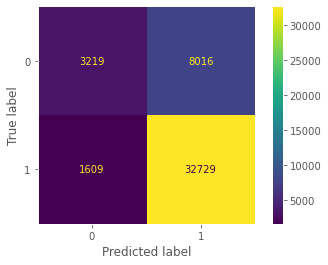

In [147]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm_rf_no_reddit = confusion_matrix(y_test_no_reddit, y_pred_no_reddit, labels=classifier_no_reddit.classes_)
cm_rf_reddit = confusion_matrix(y_test_reddit, y_pred_reddit, labels=classifier_reddit.classes_)
cm_xg_no_reddit = confusion_matrix(y_test_no_reddit, y_pred_xg_no_reddit, labels=classifier_xg_reddit.classes_)
cm_xg_reddit = confusion_matrix(y_test_reddit, y_pred_xg_reddit, labels=classifier_xg_no_reddit.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_no_reddit,
                              display_labels=classifier_no_reddit.classes_)
disp.plot()
plt.grid(False)
plt.show()

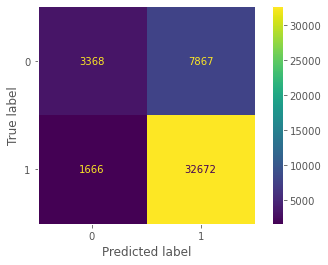

In [149]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_reddit,
                              display_labels=classifier_reddit.classes_)
disp.plot()
plt.grid(False)
plt.show()

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier_reddit.classes_)
disp.plot()
plt.grid(False)
plt.show()

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.grid(False)
plt.show()

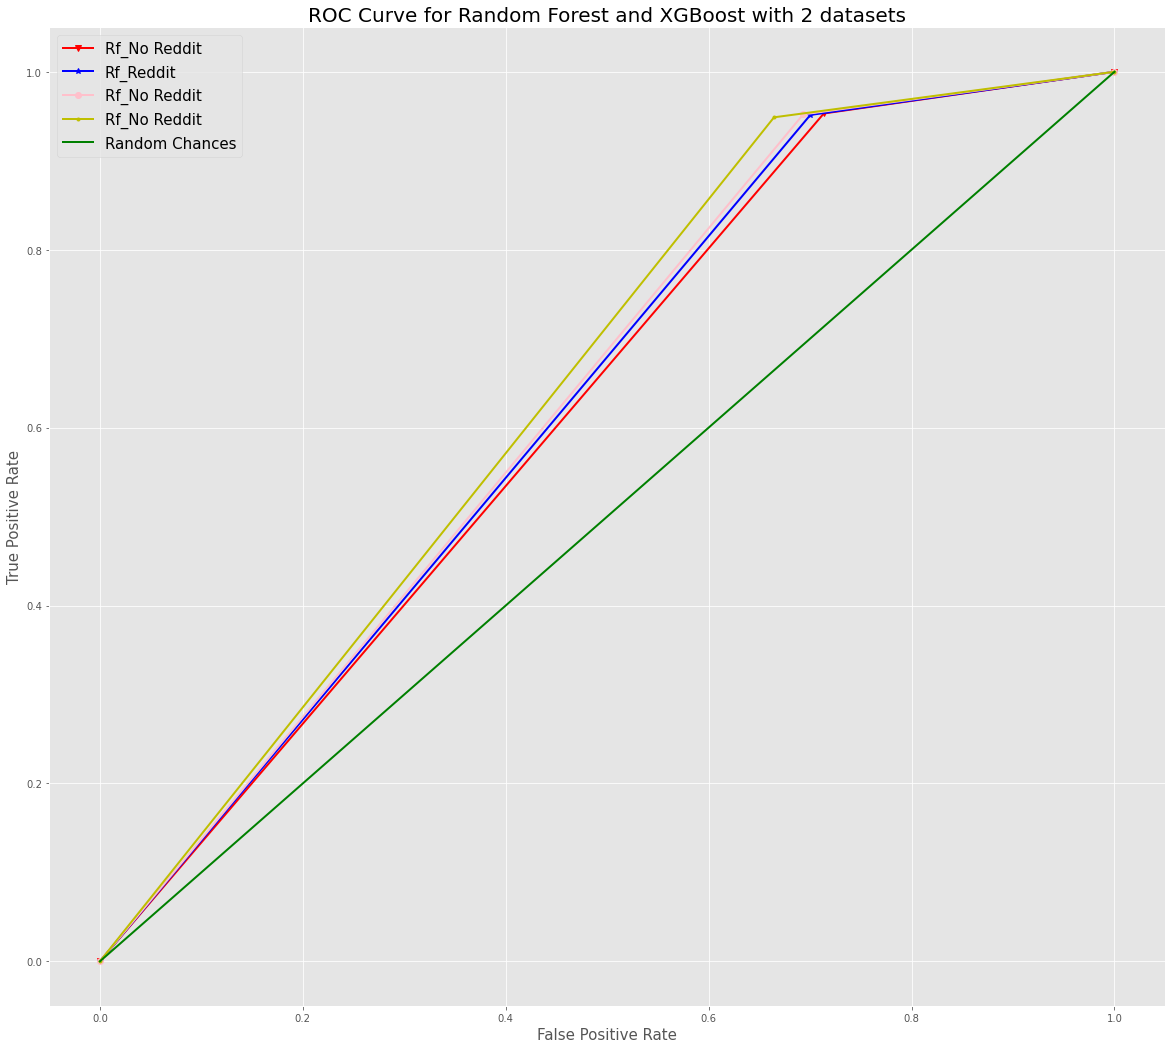

In [161]:
# roc curve and auc

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(brand_reviews_cleaned['target']))]



# calculate roc curves
a1, b1, thresh = roc_curve(y_test_no_reddit, y_pred_no_reddit)
a2, b2, thresh = roc_curve(y_test_reddit, y_pred_reddit)
a3, b3, thresh = roc_curve(y_test_no_reddit, y_pred_xg_no_reddit)
a4, b4, thresh = roc_curve(y_test_reddit, y_pred_xg_reddit)
ns_fpr, ns_tpr, thresh = roc_curve(brand_reviews_cleaned['target'], ns_probs)

plt.figure(figsize = (20, 18))

# plot the roc curve for the model
plt.plot(a1, b1,marker='v', lw=2, color='r', label='Rf_No Reddit')
plt.plot(a2, b2, marker='*', lw=2, color='b', label='Rf_Reddit')
plt.plot(a3, b3,marker='o', lw=2, color='pink',label='Xg_No Reddit')
plt.plot(a4, b4, marker='.', lw=2, color='y', label='Xg_No Reddit')
plt.plot(ns_fpr, ns_tpr, linestyle='-', lw=2, color='green', label='Random Chances')


# axis labels
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
# show the legend
plt.legend(prop={'size': 15})
plt.title("ROC Curve for Random Forest and XGBoost with 2 datasets",fontsize = 20)
# show the plot
plt.show()

In [ ]:
fpr, tpr, thresh = roc_curve(y_train, prob_train)
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label= f'ROC curve (area = {auc(fpr, tpr): 0.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC Curve Training Data', fontsize = 40)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.legend()
plt.show()